In [12]:
import mysql.connector
import re

db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "rooot", # changed mysql settings but still not letting me change it just "root" so I put it to "rooot"
    database = "CSCI_620"
    )

c = db.cursor()

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

wds = pd.read_csv('wds.csv', header = 0, dtype={'source_id': str})
mwdd = pd.read_csv('mwdd.csv', header = 0, dtype={'gaiadr2': str})

df = pd.merge(wds, mwdd, left_on='source_id', right_on='gaiadr2', how='left')
df = df.dropna(subset=['age'])
# dec is a reserved word in MySQL
df.rename(columns={'dec': 'declination'}, inplace=True)
c.execute('''
    CREATE TABLE IF NOT EXISTS white_dwarfs (
        wd VARCHAR(50),
        dr2name VARCHAR(100),
        source_id BIGINT,
        teffh FLOAT,
        loggh FLOAT,
        g_gaia_mag FLOAT,
        pwd FLOAT,
        ra FLOAT,
        declination FLOAT,
        age FLOAT
    )
''')

batch_size = 100
for start in range(0, len(df), batch_size):
    end = start + batch_size
    batch = df.iloc[start:end]
    for i, row in batch.iterrows():
        row_tuple = tuple(row[['wd', 'dr2name', 'source_id', 'teffh', 'loggh', 'g_gaia_mag', 'pwd', 'ra', 'declination', 'age']])
        c.execute('''
            INSERT INTO white_dwarfs (wd, dr2name, source_id, teffh, loggh, g_gaia_mag, pwd, ra, declination, age)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ''', row_tuple)
    db.commit()



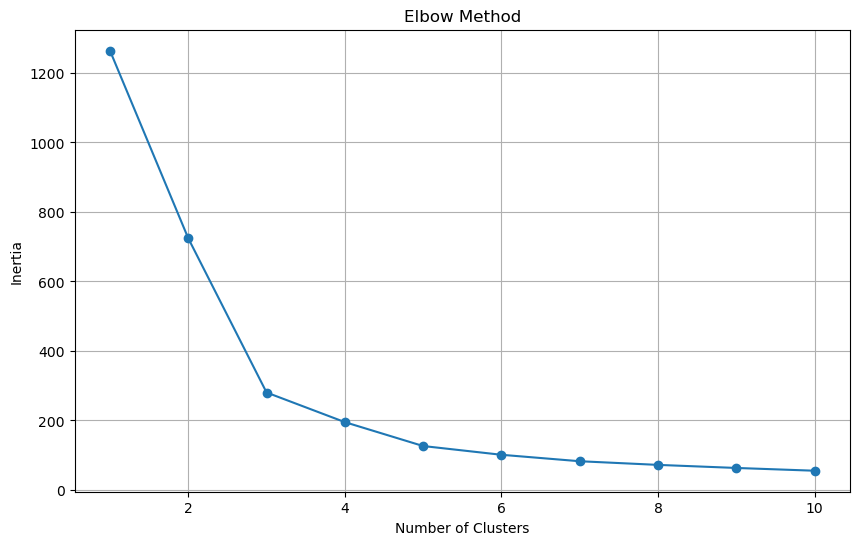

In [14]:
x_scaled = scaler.fit_transform(df[['age', 'teffh']])

inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=11)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

/Users/kevin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


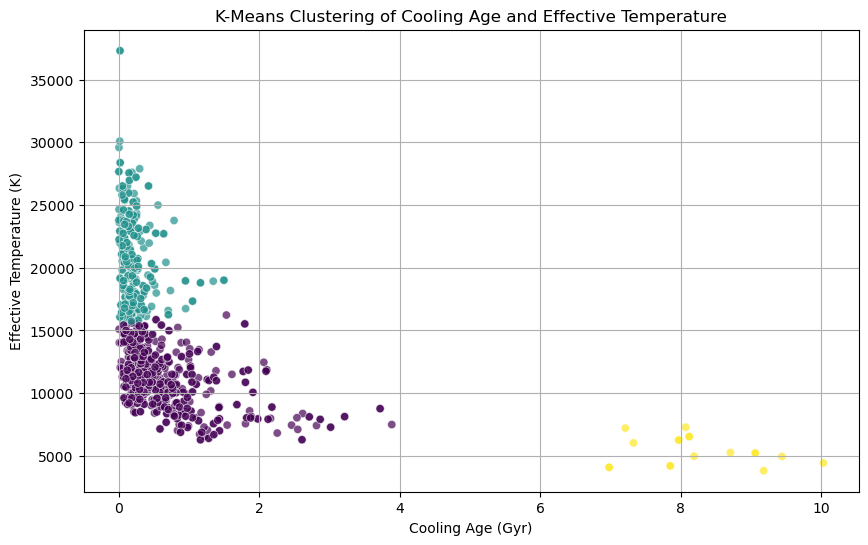

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sql_query = f"SELECT * FROM white_dwarfs LIMIT 1000"

c.execute(sql_query)
result = c.fetchall()
db.commit()
df = pd.DataFrame(result)
df.columns = [x[0] for x in c.description]

x = df[['age', 'teffh']]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

kmeans = KMeans(n_clusters=3)
kmeans.fit(x_scaled)

df['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['teffh'], c=df['cluster'], cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)
plt.xlabel('Cooling Age (Gyr)')
plt.ylabel('Effective Temperature (K)')
plt.title('K-Means Clustering of Cooling Age and Effective Temperature')
plt.grid(True)
plt.show()

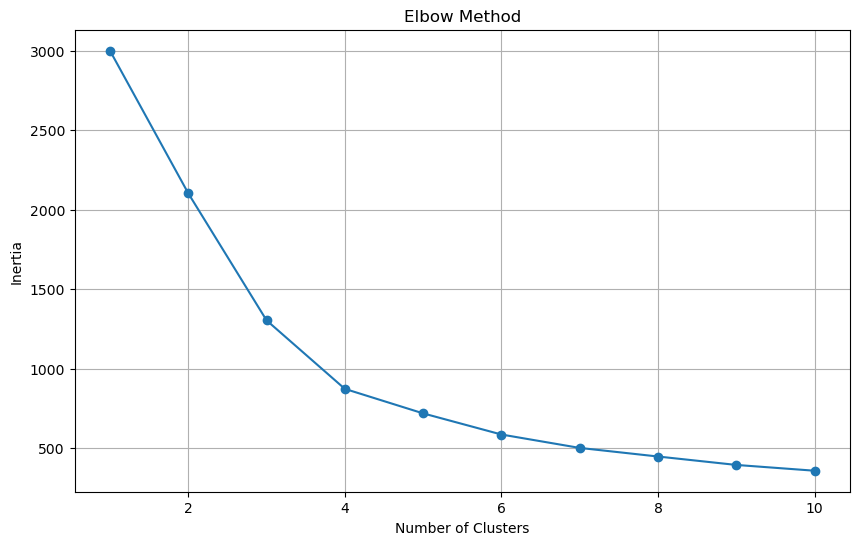

In [16]:
x = df[['age', 'teffh', 'loggh']]

x_scaled = scaler.fit_transform(x)

inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=11)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

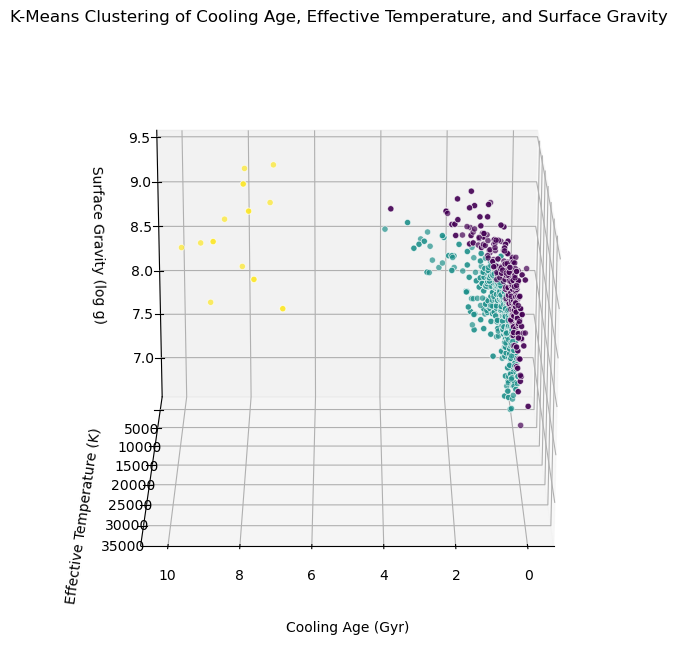

In [17]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=11)
kmeans.fit(x_scaled)
df['cluster'] = kmeans.labels_

fig = plt.figure(figsize=(12, 8))

### 111 is shorthand for dimensions in matplotlib
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['age'], df['teffh'], df['loggh'], c=df['cluster'], cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)
ax.set_xlabel('Cooling Age (Gyr)', labelpad=20)
ax.set_ylabel('Effective Temperature (K)', labelpad=20)
ax.set_zlabel('Surface Gravity (log g)', labelpad=20)
ax.set_title('K-Means Clustering of Cooling Age, Effective Temperature, and Surface Gravity')

ax.view_init(elev=20, azim=90)
plt.show()

Data inserted


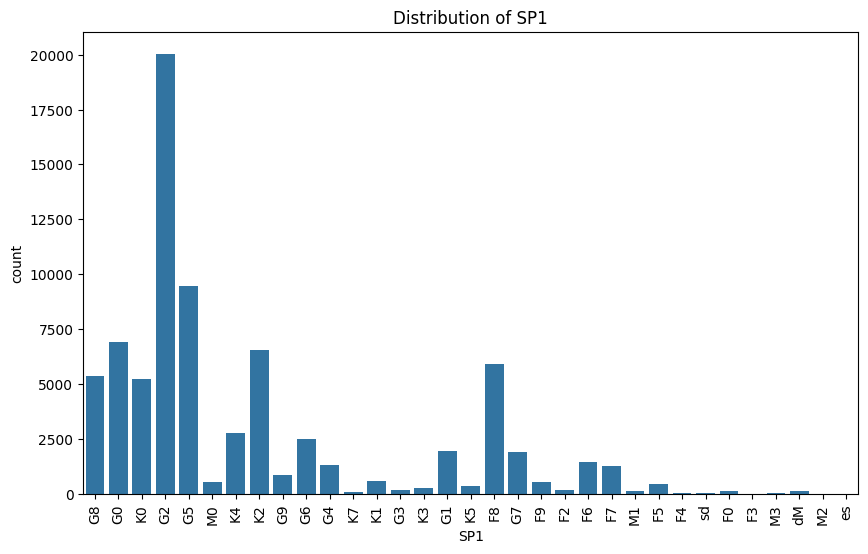

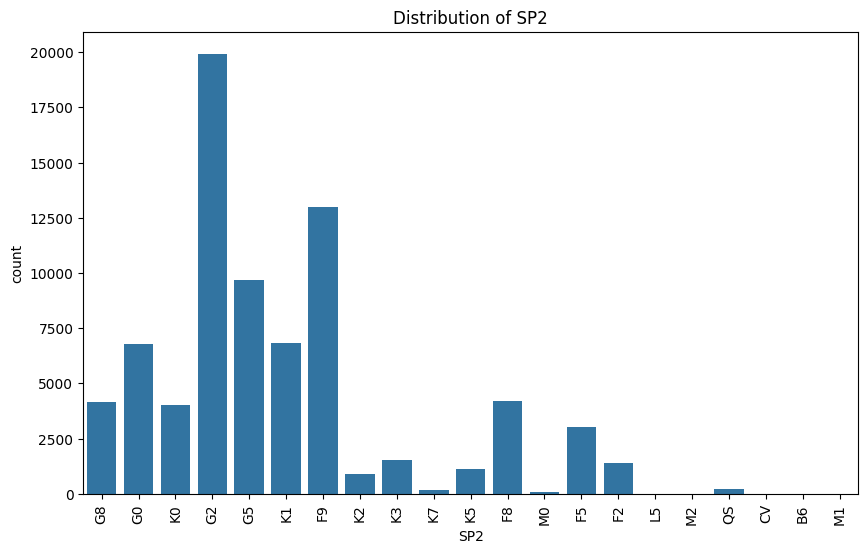

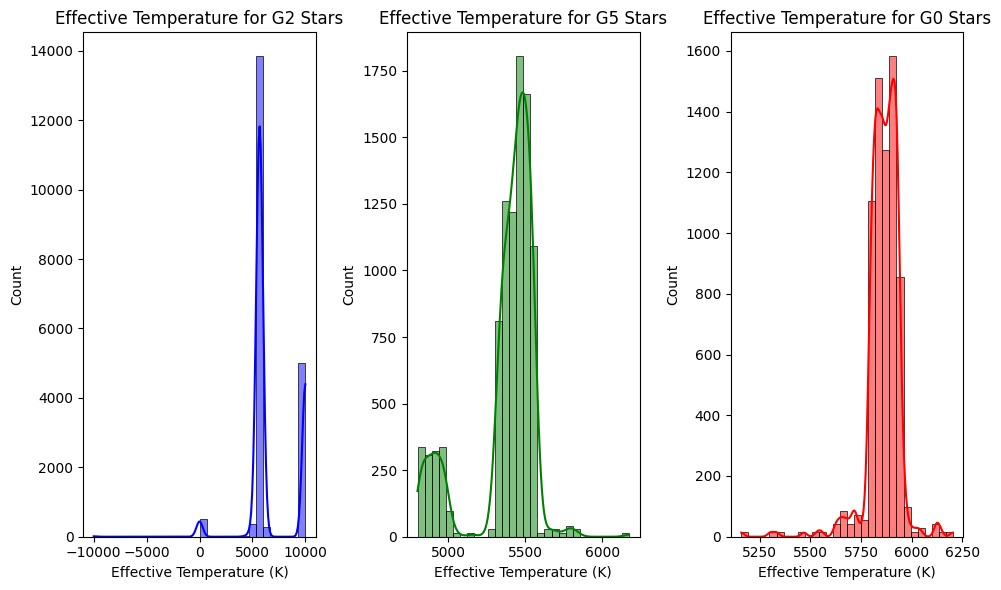

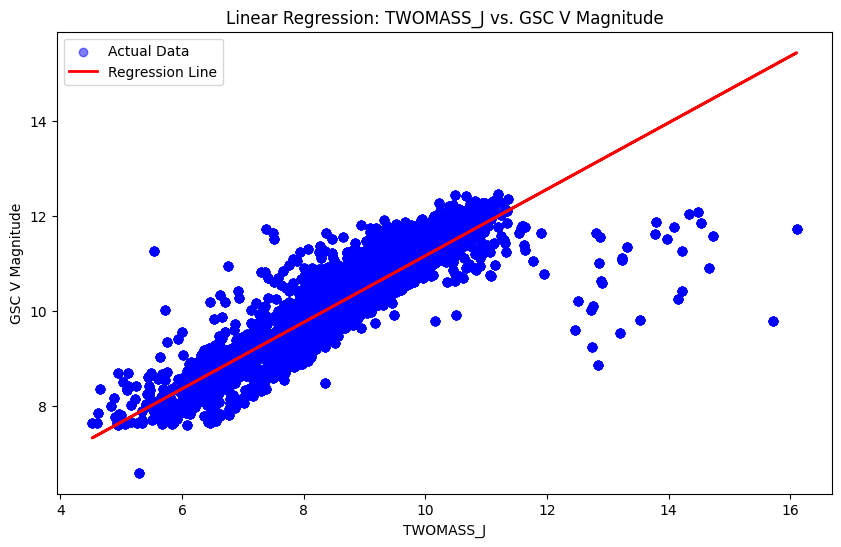

Coefficient: 0.7006143749249235
Intercept: 4.159336349375567
Mean Squared Error : 0.17563226885276165
R-squared score: 0.8035443049843078


In [32]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yash",
    database="CSCI_630_GA4"
)
# print(mydb)
cursor = mydb.cursor()
file_path = 'MyTable_0_Inferno7601.csv'
chunk_size = 1000
table_name = "MarvelsStar"

def create_table_statement(df, table_name):
    columns = []
    for col, dtype in zip(df.columns, df.dtypes):
        if "int" in str(dtype):
            sql_dtype = "INT"
        elif "float" in str(dtype):
            sql_dtype = "FLOAT"
        else:
            sql_dtype = "VARCHAR(255)"
        columns.append(f"`{col}` {sql_dtype}")
    columns_str = ", ".join(columns)
    return f"CREATE TABLE IF NOT EXISTS {table_name} ({columns_str})"

first_chunk = True
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk = chunk.where(pd.notnull(chunk), None)
    if first_chunk:
        create_table_sql = create_table_statement(chunk, table_name)
        cursor.execute(create_table_sql)
        first_chunk = False

    for i, row in chunk.iterrows():
        sql = f"INSERT INTO {table_name} ({', '.join(chunk.columns)}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, tuple(row))
    mydb.commit()

print("Data inserted")

batch_size = 1000
offset = 100
dataframes = []
valid_twomass_j_range = (0, 20)
valid_gsc_v_range = (0, 30)

while True:
    query = f"SELECT * FROM {table_name} LIMIT {batch_size} OFFSET {offset}"
    cursor.execute(query)
    rows = cursor.fetchall()
    if not rows:
        break
    column_names = [i[0] for i in cursor.description]
    dataframes.append(pd.DataFrame(rows, columns=column_names))
    offset += batch_size

df = pd.concat(dataframes, ignore_index=True)
df['SP1'] = df['SP1'].replace(["??", "-9999"], pd.NA)
df['SP2'] = df['SP2'].replace(["??", "-9999"], pd.NA)
df['SP1'] = df['SP1'].fillna(df['SP1'].mode()[0])
df['SP2'] = df['SP2'].fillna(df['SP2'].mode()[0])


# Plotting SP1 and SP2
plt.figure(figsize=(10, 6))
sns.countplot(x='SP1', data=df)
plt.title('Distribution of SP1')
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(10, 6))
sns.countplot(x='SP2', data=df)
plt.title('Distribution of SP2')
plt.xticks(rotation=90)
plt.show()


# Histplots for temperature
g2_stars = df[df['SP1'] == 'G2']
g5_stars = df[df['SP1'] == 'G5']
g0_stars = df[df['SP1'] == 'G0']


plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
sns.histplot(g2_stars['Teff'], bins=30, kde=True, color='blue')
plt.title('Effective Temperature for G2 Stars')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Count')
plt.subplot(1, 3, 2)
sns.histplot(g5_stars['Teff'], bins=30, kde=True, color='green')
plt.title('Effective Temperature for G5 Stars')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Count')
plt.subplot(1, 3, 3)
sns.histplot(g0_stars['Teff'], bins=30, kde=True, color='red')
plt.title('Effective Temperature for G0 Stars')
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#Linear Regression
df['TWOMASS_J'] = pd.to_numeric(df['TWOMASS_J'], errors='coerce')
df['GSC_V'] = pd.to_numeric(df['GSC_V'], errors='coerce')
df = df.dropna(subset=['TWOMASS_J', 'GSC_V'])
df = df[(df['TWOMASS_J'] >= valid_twomass_j_range[0]) & (df['TWOMASS_J'] <= valid_twomass_j_range[1])]
df = df[(df['GSC_V'] >= valid_gsc_v_range[0]) & (df['GSC_V'] <= valid_gsc_v_range[1])]
X = df[['TWOMASS_J']].values
y = df['GSC_V'].values
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Actual Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Linear Regression: TWOMASS_J vs. GSC V Magnitude')
plt.xlabel('TWOMASS_J')
plt.ylabel('GSC V Magnitude')
plt.legend()
plt.show()
print(f"Coefficient: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error : {mse}")
print(f"R-squared score: {r2}")


cursor.close()
mydb.close()


In [2]:
import mysql.connector
import re
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

file_path = 'marvelsStar.csv'
df = pd.read_csv(file_path)

df['SP1'] = df['SP1'].replace("??", pd.NA) 
df['SP1'] = df['SP1'].replace("-9999", pd.NA) 
df['SP2'] = df['SP2'].replace("??", pd.NA) 
df['SP2'] = df['SP2'].replace("-9999", pd.NA) 
df['SP1'] = df['SP1'].fillna(df['SP1'].mode()[0])
df['SP2'] = df['SP2'].fillna(df['SP2'].mode()[0])

In [3]:
categorical_columns = ['STARNAME', 'TWOMASS_NAME', 'Plate', 'GSC_Name', 'TYC_Name', 'HIP_Name', 'SP1', 'SP2', 'RPM_LOG_g', 'HIP_SPTYPE']
for column in categorical_columns:
    df[column] = df[column].astype('category')

In [5]:
db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = "root",
    database = "CSCI_620_GA4"
    )

mycursor = db.cursor()

In [6]:
create_table_query = f"CREATE TABLE IF NOT EXISTS marvelsStar ("
count = 0
column_names = ""
for i in range(0, 6):
    if count > 0:
        create_table_query += ", "
        column_names += ", "
    else:
        count += 1
    create_table_query += "`" + df.columns[i] + "`" + " VARCHAR(100)"
    column_names += "`" + df.columns[i] + "`"
for i in range(6, 13):
    create_table_query += ", `" + df.columns[i] + "`" + " int"
    column_names += ", `" + df.columns[i] + "`"
for i in range(13, 16):
    create_table_query += ", `" + df.columns[i] + "`" + " VARCHAR(100)"
    column_names += ", `" + df.columns[i] + "`"
for i in range(16, len(df.columns) - 1):
    create_table_query += ", `" + df.columns[i] + "`" + " int"
    column_names += ", `" + df.columns[i] + "`"
create_table_query += f", `{df.columns[len(df.columns) - 1]}` VARCHAR(100))"
column_names += ", `" + df.columns[len(df.columns) - 1] + "`"
print(column_names)
mycursor.execute(create_table_query)
db.commit()

`STARNAME`, `TWOMASS_NAME`, `Plate`, `GSC_Name`, `TYC_Name`, `HIP_Name`, `RA_Final`, `DEC_Final`, `GSC_B`, `GSC_V`, `TWOMASS_J`, `TWOMASS_H`, `TWOMASS_K`, `SP1`, `SP2`, `RPM_LOG_g`, `Teff`, `log_g`, `FeH`, `GSC_B_E`, `GSC_V_E`, `TWOMASS_J_E`, `TWOMASS_H_E`, `TWOMASS_K_E`, `Teff_E`, `log_g_E`, `FeH_E`, `Epoch_0`, `RA_0`, `DEC_0`, `RA_TWOMASS`, `DEC_TWOMASS`, `GSC_PM_RA`, `GSC_PM_DEC`, `GSC_PM_RA_E`, `GSC_PM_DEC_E`, `TYC_B`, `TYC_B_E`, `TYC_V`, `TYC_V_E`, `HIP_PLX`, `HIP_PLX_E`, `HIP_SPTYPE`


In [7]:
batch_size = 100;
batch_i = 0
loc = []
 
vallist = []
for k in range(len(df)):
    batch_i = batch_i + 1
    values = df.iloc[k].tolist()
    for i in range(len(df.columns)):
        if i in range(6, 13) or i in range(16, len(df.columns) - 1):
            print(i)
            values[i] = int(values[i])  
    vallist.append(values)
    placeholders = ", ".join(['%s'] * len(values))
    query = (f"INSERT INTO marvelsStar ({column_names}) VALUES ({placeholders})")
    if(batch_i % batch_size == 0):
        mycursor.executemany(query, vallist)
        db.commit()
        vallist = []

6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
6
7
8
9
10
11
12
16
17
18
19
20
21
22
23
24
25
26


In [8]:
columns_to_select = "`RA_Final`, `DEC_Final`, `Teff`, `FeH`, `log_g`"
sql_query = f"SELECT {columns_to_select} FROM marvelsStar"
mycursor.execute(sql_query)
result = mycursor.fetchall()
db.commit()
df_marvel = pd.DataFrame(result, columns=columns_to_select.split(", "))
df_marvel

`RA_Final`  `DEC_Final`  `Teff`  `FeH`  `log_g`
0              84            5    5624      0        4
1              84            5    5624      0        4
2              84            4    5666      0        3
3              84            4    5666      0        3
4              85            5    5157      0        4
...           ...          ...     ...    ...      ...
21995         176            1    5121      0        4
21996         176            1    6087      0        4
21997         176            1    6087      0        4
21998         176            1    5715      0        4
21999         176            1    5715      0        4

[22000 rows x 5 columns]

In [9]:
Q1 = df_marvel["`log_g`"].quantile(0.25)
Q3 = df_marvel["`log_g`"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_marvel = df_marvel[(df_marvel["`log_g`"] >= lower_bound) & (df_marvel["`log_g`"] <= upper_bound)]

c:\Users\dharm\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\dharm\AppData\Local\Temp\ipykernel_30680\814577245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_marvel['Cluster'] = kmeans.fit_predict(df_marvel[['`RA_Final`', '`DEC_Final`']])


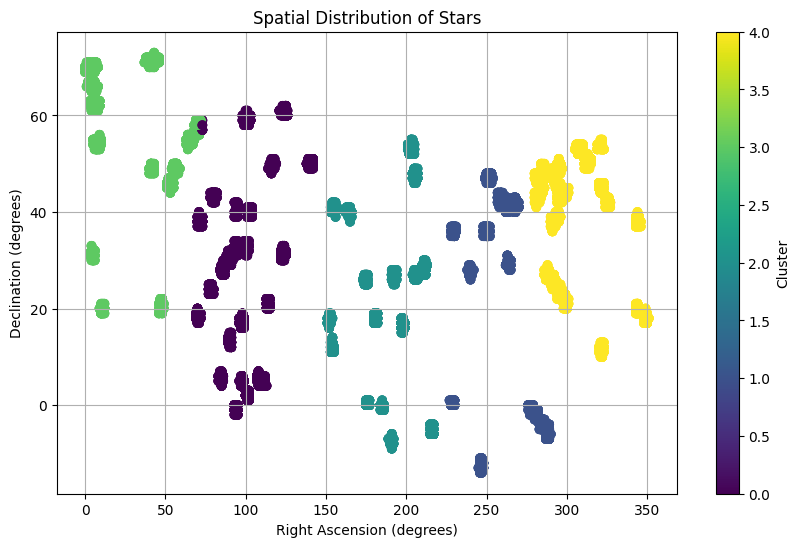

In [10]:
k = 5  
kmeans = KMeans(n_clusters=k)

df_marvel['Cluster'] = kmeans.fit_predict(df_marvel[['`RA_Final`', '`DEC_Final`']])

plt.figure(figsize=(10, 6))
plt.scatter(df_marvel['`RA_Final`'], df_marvel['`DEC_Final`'], c=df_marvel['Cluster'], cmap='viridis', marker='o')
plt.title('Spatial Distribution of Stars')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

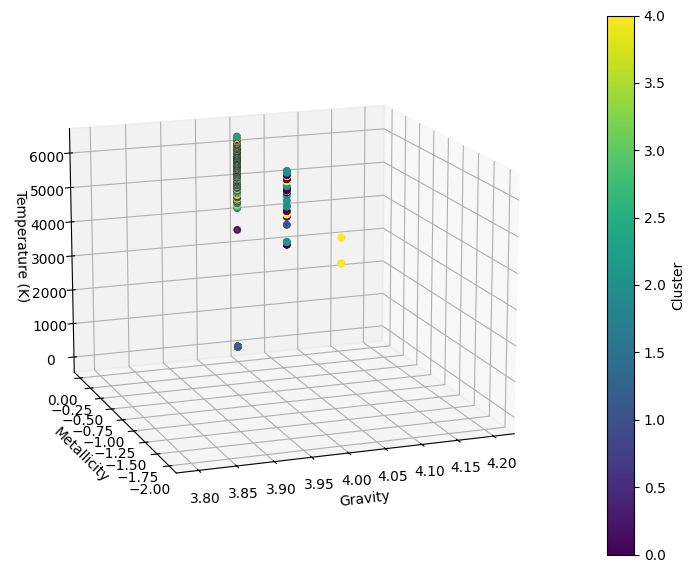

In [11]:
log_g = df_marvel['`log_g`']
feh = df_marvel['`FeH`']
teff = df_marvel['`Teff`']


fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(log_g, feh, teff, c=df_marvel["Cluster"], cmap='viridis', marker='o')

ax.set_xlabel('Gravity')
ax.set_ylabel('Metallicity')
ax.set_zlabel('Temperature (K)')
ax.view_init(elev=15, azim=250) 

cbar = plt.colorbar(sc)
cbar.set_label('Cluster')

plt.show()

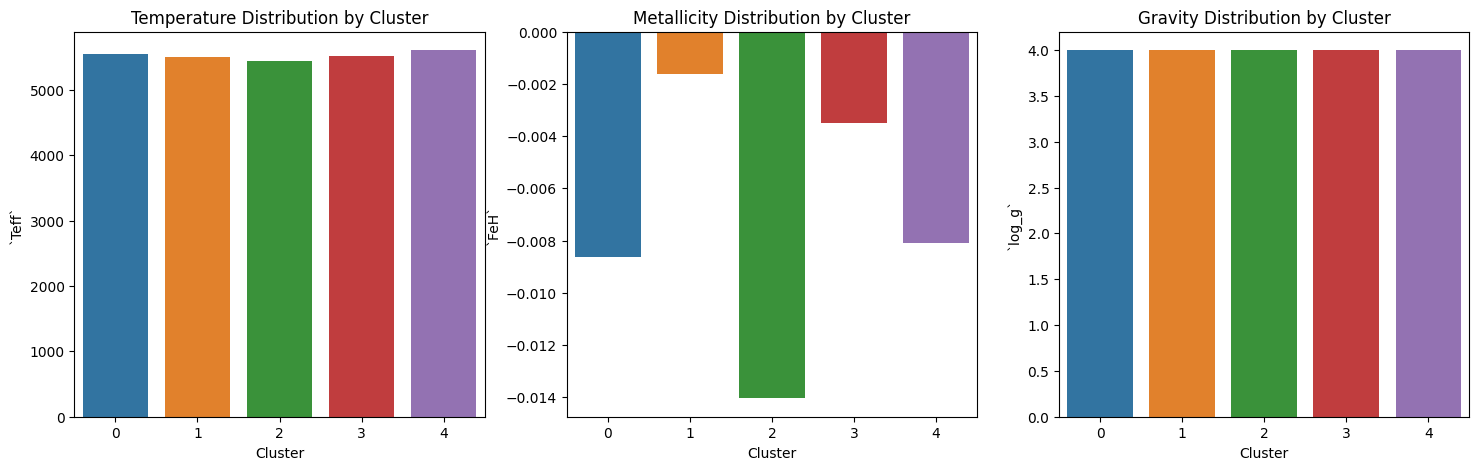

In [12]:
cluster_properties = df_marvel.groupby('Cluster')[['`Teff`', '`FeH`', '`log_g`']].mean()

# Plotting cluster properties
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=cluster_properties.index, y='`Teff`', data=cluster_properties, ax=axes[0])
axes[0].set_title('Temperature Distribution by Cluster')
sns.barplot(x=cluster_properties.index, y='`FeH`', data=cluster_properties, ax=axes[1])
axes[1].set_title('Metallicity Distribution by Cluster')
sns.barplot(x=cluster_properties.index, y='`log_g`', data=cluster_properties, ax=axes[2])
axes[2].set_title('Gravity Distribution by Cluster')
plt.show()

In [13]:
columns_to_select_3 = "`HIP_SPTYPE`, `RA_Final`, `DEC_Final`, `GSC_B`, `GSC_V`, `TWOMASS_J`, `TWOMASS_H`, `TWOMASS_K`, `Teff`, `log_g`, `FeH`"
sql_query = f"SELECT {columns_to_select_3} FROM marvelsStar where `HIP_SPTYPE` NOT IN ('-9999')"
mycursor.execute(sql_query)
result = mycursor.fetchall()
db.commit()
df_marvel_3 = pd.DataFrame(result, columns=columns_to_select_3.split(", "))

In [14]:
X = df_marvel_3[['`RA_Final`', '`DEC_Final`', '`GSC_B`', '`GSC_V`', '`TWOMASS_J`', '`TWOMASS_H`', '`TWOMASS_K`', '`Teff`', '`log_g`', '`FeH`']]
Y = df_marvel_3['`HIP_SPTYPE`']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

clf.fit(X_train, Y_train)

DecisionTreeClassifier()

In [18]:
from sklearn.metrics import classification_report, accuracy_score
Y_pred = clf.predict(X_test)

print(classification_report(Y_test, Y_pred))
print("Accuracy:", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

       F7Vws       1.00      1.00      1.00         1
          F8       0.83      1.00      0.91        20
         F8V       1.00      1.00      1.00         1
          G0       1.00      1.00      1.00        41
         G1V       1.00      1.00      1.00         4
       G2III       1.00      1.00      1.00         2
         G2V       1.00      1.00      1.00         1
       G2Vws       1.00      1.00      1.00         1
          G5       1.00      1.00      1.00        40
         G6V       1.00      1.00      1.00         1
         G8V       1.00      1.00      1.00         1
          Gp       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         2
          K0       1.00      0.98      0.99        51
       K0III       1.00      1.00      1.00         2
       K1III       1.00      1.00      1.00         1
    K1III-IV       1.00      1.00      1.00         1
        K1IV       1.00    

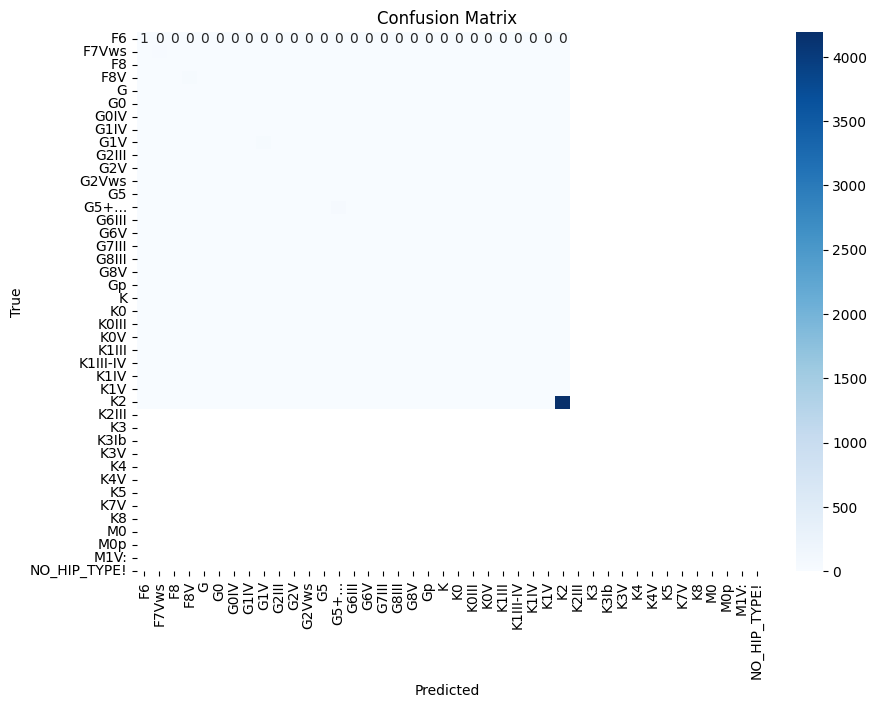

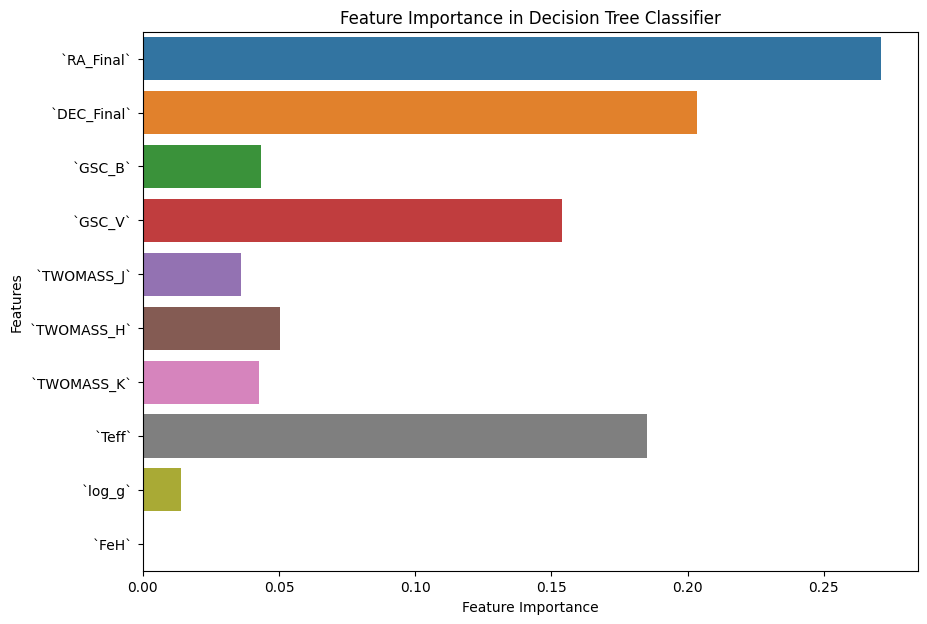

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

feature_importance = clf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importance, y=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Decision Tree Classifier')
plt.show()